In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso
from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

import GPy

from jaxbo.mcmc_models import ReimannianMFGPclassifierFourier, ReimannianGPclassifierFourier
from jaxbo.input_priors import uniform_prior
from sklearn.metrics import balanced_accuracy_score
from meshutils.Mesh import Mesh
import meshio
from scipy.linalg import eigh

In [2]:
def plotmesh(elements, node_X, c_elem, title='mesh'):
    n_elem = len(elements)
    fig, ax = plt.subplots(figsize=(15,7))

    r = np.abs(np.max(node_X)-np.min(node_X))
    ax.set_xlim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_ylim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_aspect('equal')
    patches=[]
    #viridis = matplotlib.cm.get_cmap('viridis', 50)
    colors = np.zeros((n_elem))
    for i in range(n_elem):
        n1 = elements[i,0]
        n2 = elements[i,1]
        n3 = elements[i,2]
        n4 = elements[i,3]
        polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], edgecolor='r', facecolor=None, closed=True)
        patches.append(polygon)
        colors[i] = c_elem[i] #0.25*(aux_X[n1] + aux_X[n2] + aux_X[n3] + aux_X[n4])
    p = PatchCollection(patches, edgecolor='k', facecolor='gray')
    p.set_array(colors)
    ax.add_collection(p)
    ax.set_title(title)
    return fig, ax

def reverse_sde2(rng, initial, forward_drift, dispersion, score, ts=train_ts): # Pass in the initial noise from outside
    def f(carry, params):
        t, dt = params
        x, rng = carry
        rng, step_rng = jax.random.split(rng)
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        noise = random.normal(step_rng, x.shape)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return (x, rng), ()
    
    rng, step_rng = random.split(rng)
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = scan(f, (initial, rng), params)
    return x

def reverse_sde3(initial, forward_drift, dispersion, score, noises, ts=train_ts): # Pass in both the initial noise and the "infused" noise from outside
    def f(carry, params):
        t = params[0]
        dt = params[1]
        noise = params[2:]
        x = carry
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return x, ()
    
    dts = ts[1:] - ts[:-1]
    params = jnp.hstack([train_ts[:-1][:,None], dts[:,None], noises])
    x, _ = scan(f, initial, params)
    return x

In [4]:
# Now, for every set of initial noise do the diffusion, obtain the NODE params and paint the elements according to the stress at equi lambda=1.1
with open('params/mice_std_x.npy', 'rb') as f:
    std_x = pickle.load(f)
with open('params/mice_mu_x.npy', 'rb') as f:
    mu_x = pickle.load(f)
with open('params/mice_diffusion_params.npy', 'rb') as f:
    params_diff = pickle.load(f)
# These are repeated stuff and loading of the above ^ data in case you need to start right with the diffusion
with open('params/mice_node_params_all.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_sample_params.npy', 'rb') as f:
    Sample_params = pickle.load(f)
unravel_params = ravel_pytree(Sample_params[0])[1]
normalization = [3.0,3.0,1.0,1.0]

## Try in python first

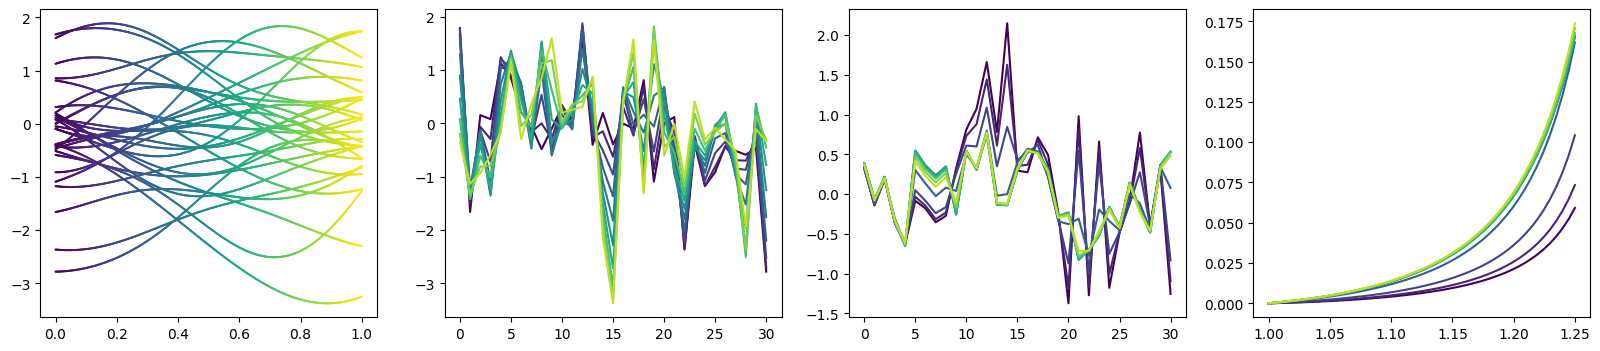

In [135]:
n_params = 31

k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)
X = np.linspace(0.,1.0,500)
X = X[:,None]
mu = np.zeros((500))
C = k.K(X,X)
Z = np.random.multivariate_normal(mu,C,n_params)

cmap = matplotlib.cm.get_cmap('viridis')
fig, ax = plt.subplots(1,4, figsize=(20,4))
header1 = "x"
for i in range(n_params):
    ax[0].scatter(X, Z[i], c=X, marker='.', s=1.0)
    header1+= " y" + str(i)
header2 = "x"
for i in range(10):
    ax[1].plot(Z[:,i*50], c=cmap(i/10))
    header2+= " y" + str(i)



score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)

n_params = 31
lmbx = np.linspace(1,1.25)
diff_params = []
stress_preds = [lmbx]
for i, initial in enumerate(Z[:,::50].T):
    initial = initial[None,:]
    l = reverse_sde2(rng, initial, drift, dispersion, trained_score)[0]
    ax[2].plot(l, c=cmap(i/10))
    diff_params.append(l)
    l_unscaled = l*std_x+mu_x 

    sample_params = unravel_params(l_unscaled)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params, normalization) 
    sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi

    ax[3].plot(lmbx, sigx, c=cmap(i/10))
    stress_preds.append(sigx*1000)
diff_params = np.array(diff_params)
stress_preds = np.array(stress_preds)


out = np.hstack([X,Z.T])[::10]
out[-1,0] = 1.0
np.savetxt('tikz/fig_correlation_data/gauss_fields.csv', out, header=header1, comments="")
np.savetxt('tikz/fig_correlation_data/diff_inputs.csv', np.hstack([np.arange(31)[:,None], Z[:,::50]]), header=header2, comments="")
np.savetxt('tikz/fig_correlation_data/diffused_params.csv', np.hstack([np.arange(31)[:,None], diff_params.T]), header=header2, comments="")
np.savetxt('tikz/fig_correlation_data/stress_preds.csv', stress_preds.T, header=header2, comments="")

In [12]:
#Generate a simple rectangular mesh
nrow = 20
ncol = 20
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
node_X, node_Y = np.meshgrid(np.linspace(0,1,nrow),np.linspace(0,1,ncol))
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

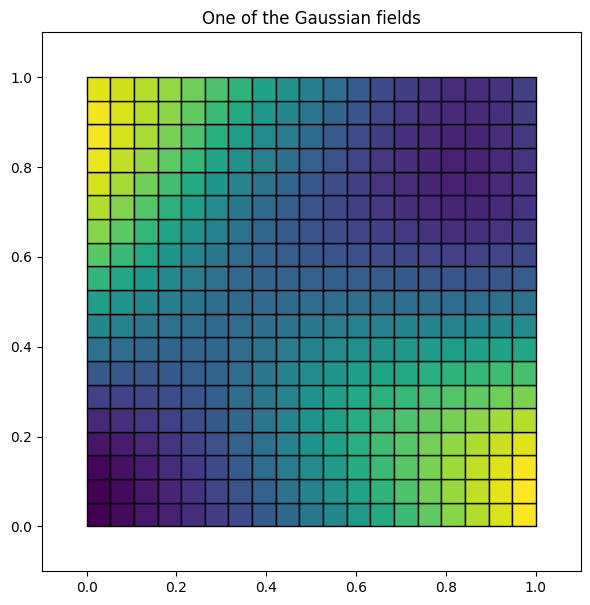

In [23]:
k = GPy.kern.RBF(input_dim=2,lengthscale=0.4)
mu = np.zeros((node_X.shape[0]))
C = k.K(node_X,node_X)
Z = np.random.multivariate_normal(mu,C,n_params)

c_elem = 0.25*(Z[0][elements[:,0]] + Z[0][elements[:,1]] + Z[0][elements[:,2]] + Z[0][elements[:,3]])
plotmesh(elements, node_X, c_elem, title='One of the Gaussian fields'); 

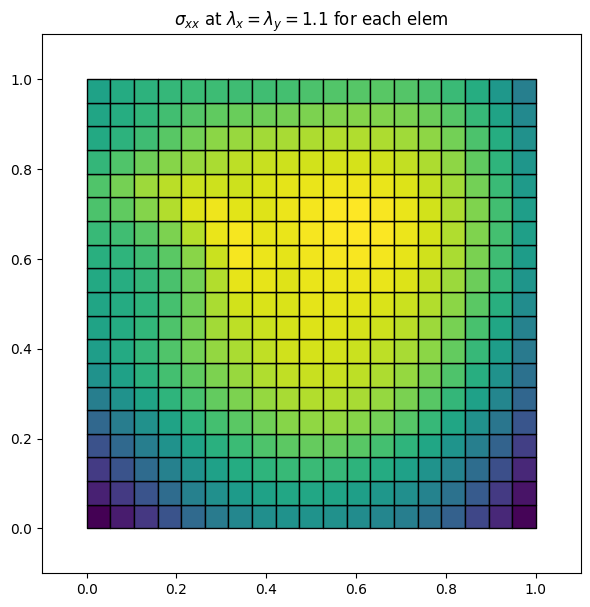

In [33]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)

n_params = 31
stat = [] # statistic of interest
for initial in Z.T:
    initial = initial[None,:]
    l = reverse_sde2(rng, initial, drift, dispersion, trained_score)[0]
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params, normalization)
    lmbx = np.linspace(1,1.1) 
    sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    stat.append(sigx[-1])
stat = np.array(stat)

c_elem = 0.25*(stat[elements[:,0]] + stat[elements[:,1]] + stat[elements[:,2]] + stat[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='$\sigma_{xx}$ at $\lambda_x=\lambda_y=1.1$ for each elem'); 

This is working well, but to be extra careful we need to pass in the random noise from spatially correlated GPs

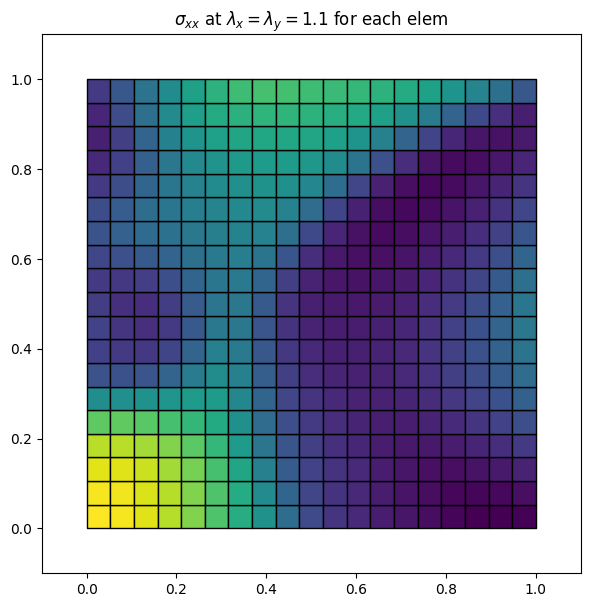

In [35]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)

D = train_ts.shape[0]-1
n_params = 31
k = GPy.kern.RBF(input_dim=2,lengthscale=0.5)
mu = np.zeros((node_X.shape[0]))
C = k.K(node_X,node_X)
Z_p = np.random.multivariate_normal(mu,C,n_params).T # Random normal noise for the initial value
# Z_t = np.random.multivariate_normal(mu,C,D) # Random normal noise for each step
Z_t = []
for i in range(D):
    Z_t.append(np.random.multivariate_normal(mu,C,n_params))
Z_t = np.array(Z_t).transpose([2,0,1])

stat = []
for initial, noise in zip(Z_p, Z_t):
    initial = initial[None,:]
    l = reverse_sde3(initial, drift, dispersion, trained_score, noise)[0]
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params, normalization)
    lmbx = np.linspace(1,1.1) 
    sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    stat.append(sigx[-1])
stat = np.array(stat)

c_elem = 0.25*(stat[elements[:,0]] + stat[elements[:,1]] + stat[elements[:,2]] + stat[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='$\sigma_{xx}$ at $\lambda_x=\lambda_y=1.1$ for each elem'); 

## Abaqus

### Common parameters

In [14]:
# Write the common parameters
n_neurons = 5
with open('params/mice_node_m_width_' + str(n_neurons) + '.npy', 'rb') as f:
    params_all = pickle.load(f)
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = params_all
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights
params_I1c,params_I1s = params_I1
params_I2c,params_I2s = params_I2
params_1_vc,params_1_vs = params_1_v
params_1_wc,params_1_ws = params_1_w
params_v_wc,params_v_ws = params_v_w
normalization = [3.0,3.0,1.0,1.0]

aux, unravel = ravel_pytree(params_I1)
params_Iv   = unravel(aux*0) #Just create dummy empty params lists because the current fem expects all of these different combinations
params_Iw   = unravel(aux*0)
params_1_2  = unravel(aux*0)
params_2_v  = unravel(aux*0)
params_2_w  = unravel(aux*0)

NODE_weights = [params_I1, params_I2, params_Iv, params_Iw, params_1_2, params_1_v, params_1_w, params_2_v, params_2_w, params_v_w]
NODE_weights = ravel_pytree(NODE_weights)[0]


n_layers = 4
n_input = 1
n_weights = 35
n_biases = 11
n_neuronsperlayer = np.array([1,5,5,1])
I1_factor, I2_factor, Iv_factor, Iw_factor = normalization
activtypes = np.array([3, 3, 0])
Iweights = np.array([0.5, alpha[0], alpha[1], 0.5, 0.5, alpha[2]]) # Just put 0.5 for the unused combinations
theta = theta
Psi1_bias = Psi1_bias
Psi2_bias = Psi2_bias
Kvol = 1.0

p = np.hstack([n_layers, n_input, n_weights, n_biases, n_neuronsperlayer, I1_factor, I2_factor, Iv_factor, Iw_factor, 
               NODE_weights, activtypes, Iweights, theta, Psi1_bias, Psi2_bias, Kvol])
nprops = p.shape[0] #371


inpstr = []
nrows = np.ceil(nprops/8)
for i in range(int(nrows)):
    i1 = i*8
    i2 = i1+8
    if p.shape[0] < i2:
        l = p.shape[0]-i1
        i2 = i1+l
        inpstr.append(str('%.17f, '*l % tuple(p[i1:i2])))
    else:
        inpstr.append(str('%.17f, '*8 % tuple(p[i1:i2])))
        inpstr.append(str('\n'))
inpstr.append(str('\n'))


root = 'fem/homogeneous/'
name = 'uniaxial_2D_L_coarse'
file = root + name + '.inp'
#Read Abaqus input file
inp_hndl = open(file, 'r')
inp_cont = inp_hndl.read()
inp_hndl.close

# Inject the header
i1 = inp_cont.find('*Anisotropic Hyperelastic')
i2 = i1 + inp_cont[i1:].find('\n')
header = '*Anisotropic Hyperelastic, user, formulation=INVARIANT, type=INCOMPRESSIBLE, local direction=2, properties=' + str(nprops) + ', moduli=INSTANTANEOUS'
inp_cont = inp_cont[:i1] + header + inp_cont[i2:]

i1 = inp_cont.find('*Anisotropic Hyperelastic')
i1 = i1 + inp_cont[i1:].find('\n') + 1
part1 = inp_cont[:i1]

i2 = i1 + inp_cont[i1:].find('**')
part2 = inp_cont[i2:]

with open(file, 'w') as f:
    f.write(part1)
    f.writelines(inpstr)
    f.write(part2)

### Sample parameters

In [15]:

with open(file) as f:
    lines = [line.rstrip('\n') for line in f]

# Get the elements (only needed for plotting the mesh)
i1 = -1
i2 = -1
for i, line in enumerate(lines):
    if line.find('*Element') >= 0:
        # get the element type
        j = line.find('=')
        elemtype = line[j+1:]
        i1 = i+1
        break


for j, line in enumerate(lines[i1:]):
    if line.find('*') >= 0:
        i2 = i1+j
        break
elems = lines[i1:i2]
elems = [line.split() for line in elems]
elems = [[a.rstrip(',') for a in line] for line in elems]
elems = np.array(elems, dtype=int)
elems = elems[:,1:]


# Get the nodes
i1 = -1
i2 = -1
for i, line in enumerate(lines): # Find the line that starts with '*Node'
    if line.find('*Node') >= 0:
        i1 = i+1
        break
for i, line in enumerate(lines): # Find the line that starts with '*Element' 
    if line.find('*Element') >= 0:
        i2 = i
        break
lines = lines[i1:i2]
lines = [line.split() for line in lines]
lines = [[a.rstrip(',') for a in line] for line in lines]
node_X = np.array(lines, dtype=float)
nodes = np.array(node_X[:,0],dtype=int)
node_X = node_X[:,1:3]

In [26]:
with open('params/mice_std_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    std_x = pickle.load(f)
with open('params/mice_mu_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    mu_x = pickle.load(f)
with open('params/mice_diffusion_params_width_' + str(n_neurons) + '.npy', 'rb') as f:
    params_diff = pickle.load(f)

score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)

D = train_ts.shape[0]-1
n_params = 31
k = GPy.kern.RBF(input_dim=2,lengthscale=0.4*np.max(node_X))
mu = np.zeros((node_X.shape[0]))
C = k.K(node_X,node_X)*0.2
Z_p = np.random.multivariate_normal(mu,C,n_params).T # Random normal noise for the initial value
Z_t = np.random.multivariate_normal(mu,C,size=(D,n_params)).transpose([2,0,1]) #[node_X.shape[0], D, n_params]

Sample_params = []
for i, (initial, noise) in enumerate(zip(Z_p, Z_t)):
    initial = initial[None,:]
    l = reverse_sde3(initial, drift, dispersion, trained_score, noise)[0]
    l_unscaled = l*std_x+mu_x 
    Sample_params.append(l_unscaled)

np.savetxt('fem/heterogeneous/sample_params_' + name + '.txt', Sample_params)

Edit the abaqus file

In [27]:
with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'rb') as f:
    temp = pickle.load(f)
unravel_params = ravel_pytree(temp[0])[1]

Sample_params = np.loadtxt('fem/heterogeneous/sample_params_' + name + '.txt') # [n_node, 31]

source_root = 'fem/homogeneous/'
destin_root = 'fem/heterogeneous/'
source = source_root + name + '.inp'
destin = destin_root + name + '.inp'
with open(source) as f:
    inptxt = f.read()

# Find the instance name
i1 = inptxt.find('*Instance')
i1 = i1 + inptxt[i1:].find('=') + 1
i2 = i1 + inptxt[i1:].find(',')
instname = inptxt[i1:i2]

# Define node sets for each node
i = inptxt.find('*Assembly')
i = i + inptxt[i:].find('*Nset')
part1, part2 = inptxt[:i], inptxt[i:]
for node in nodes:
    part1 += "*Nset, nset=myset-" + str(node) + ", instance=" + instname + " \n " + str(node) + ",\n"
inptxt = part1+part2

# Define field variables for each node set
i = inptxt.find("** ----")
part1, part2 = inptxt[:i], inptxt[i:]
part1 += "** \n** PREDEFINED FIELDS\n** \n"
k = 1
for i in range(len(nodes)):
    node = nodes[i]
    for j, param in enumerate(Sample_params[i]):
        part1 += "** Name: myfield-" + str(k) + "   Type: Field\n*Initial Conditions, type=FIELD, variable=" + str(j+1) + "\nmyset-" + str(node) + ", " + str(param) + "\n"
        k+= 1
inptxt = part1+part2
with open(destin, 'w') as f:
    f.write(inptxt)

In [ ]:
n_elem = len(elems)
c_elem = np.zeros(n_elem)
for i in range(n_elem):
    sample_params = Sample_params[elems[i]-1,:].mean(axis=0)
    sample_params = unravel_params(sample_params)
    params = merge_weights_aniso(params_all, sample_params)
    model = NODE_model_aniso(params, normalization)
    lmbx = 1.2
    lmby = 1.0/np.sqrt(lmbx)
    sigx, sigy = eval_Cauchy_aniso(lmbx,lmby, model)

    c_elem[i] = sigx
plotmesh(elems, node_X, c_elem, title="$\sigma_{xx}$ at $\lambda_x=1.2$, uniaxial, for each element")

### Check outputs of abaqus

In [8]:
from utils_node import NODE

In [16]:
# sample_params = Sample_params[elems[288]-1,:].mean(axis=0)
# sample_params = unravel_params(sample_params)
# params_I1si, params_I2si, params_1_vsi, params_1_wsi, params_v_wsi, theta, Psi1_bias, Psi2_bias, alpha = sample_params
# theta = 0.0
# params_I1   = (params_I1c,  params_I1si)
# params_I2   = (params_I2c,  params_I2si)
# params_1_v  = (params_1_vc, params_1_vsi)
# params_1_w  = (params_1_wc, params_1_wsi)
# params_v_w  = (params_v_wc, params_v_wsi)
# NODE_weights = params_I1, params_I2, params_1_v, params_1_w, params_v_w
# params_all = (NODE_weights, theta, Psi1_bias, Psi2_bias, alpha)

with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = params_all
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights
params_I1c,params_I1s = params_I1
params_I2c,params_I2s = params_I2
params_1_vc,params_1_vs = params_1_v
params_1_wc,params_1_ws = params_1_w
params_v_wc,params_v_ws = params_v_w


def Psi1(I1, Iv, Iw):
    I1 = (I1-3.0)/I1_factor
    Iv = (Iv-1.0)/Iv_factor
    Iw = (Iw-1.0)/Iw_factor
    Psi1 = NODE(I1, params_I1)
    a1 = jax.nn.sigmoid(alpha[0])
    Psiv_1 = NODE(a1*I1 + (1.0-a1)*Iv, params_1_v)
    Psiv_1 = jnp.maximum(Psiv_1, 0.0)
    a2 = jax.nn.sigmoid(alpha[1])
    Psiw_1 = NODE(a2*I1 + (1.0-a2)*Iw, params_1_w)
    Psiw_1 = jnp.maximum(Psiw_1, 0.0)
    return Psi1, Psiv_1, Psiw_1, Psi1 + Psiv_1*a1 + Psiw_1*a2 + jnp.exp(Psi1_bias)
def Psi2(I2):
    I2 = (I2-3.0)/I2_factor
    Psi2 = NODE(I2, params_I2)
    return Psi2, Psi2 + jnp.exp(Psi2_bias)
def Psiv(I1, Iv, Iw):
    I1 = (I1-3.0)/I1_factor
    Iv = (Iv-1.0)/Iv_factor
    Iw = (Iw-1.0)/Iw_factor
    a1 = jax.nn.sigmoid(alpha[0])
    Psi1_v = NODE(a1*I1 + (1.0-a1)*Iv, params_1_v)
    Psi1_v = jnp.maximum(Psi1_v, 0.0)
    a2 = jax.nn.sigmoid(alpha[2])
    Psiw_v = NODE(a2*Iv + (1.0-a2)*Iw, params_v_w)
    Psiw_v = jnp.maximum(Psiw_v, 0.0)
    return Psi1_v, Psiw_v, Psi1_v*(1.0-a1) + Psiw_v*a2
def Psiw(I1, Iv, Iw):
    I1 = (I1-3.0)/I1_factor
    Iv = (Iv-1.0)/Iv_factor
    Iw = (Iw-1.0)/Iw_factor
    a1 = jax.nn.sigmoid(alpha[1])
    Psi1_w = NODE(a1*I1 + (1.0-a1)*Iw, params_1_w)
    Psi1_w = jnp.maximum(Psi1_w, 0.0)
    a2 = jax.nn.sigmoid(alpha[2])
    Psiv_w = NODE(a2*Iv + (1.0-a2)*Iw, params_v_w)
    Psiv_w = jnp.maximum(Psiv_w, 0.0)
    return Psi1_w, Psiv_w, Psi1_w*(1.0-a1) + Psiv_w*(1.0-a2)
def inputs(I1, I2, Iv, Iw):
    I1 = (I1-3.0)/I1_factor
    I2 = (I2-3.0)/I2_factor
    Iv = (Iv-1.0)/Iv_factor
    Iw = (Iw-1.0)/Iw_factor
    a2 = jax.nn.sigmoid(alpha[0])
    a3 = jax.nn.sigmoid(alpha[1])
    a6 = jax.nn.sigmoid(alpha[2])
    J1 = 0.0
    J2 = a2*I1 + (1.0-a2)*Iv
    J3 = a3*I1 + (1.0-a3)*Iw
    J4 = 0.0
    J5 = 0.0
    J6 = a6*Iv + (1.0-a6)*Iw
    return I1, I2, Iv, Iw, J1, J2, J3, J4, J5, J6

I1 = 3.10919650362040
I2 = 3.09808740965782
Iv = 1.44000000000000
Iw = 0.788665719981463

print('alpha weights before sigmoiding')
print(0.5, alpha[0], alpha[1], 0.5, 0.5, alpha[2])
print('alpha weights after sigmoiding')
print(jax.nn.sigmoid(0.5), jax.nn.sigmoid(alpha[0]), jax.nn.sigmoid(alpha[1]), jax.nn.sigmoid(0.5), jax.nn.sigmoid(0.5), jax.nn.sigmoid(alpha[2]))
print('Inputs of NODEs')
print(*inputs(I1, I2, Iv, Iw))
print('Weights of NODEs')
print('params_I1')
print(params_I1)
print('params_I2')
print(params_I2)
print('params_Iv')
print(params_Iv)
print('params_Iw')
print(params_Iw)
print('params_J1')
print(0.0)
print('params_J2')
print(params_1_v)
print('params_J3')
print(params_1_w)
print('params_J4')
print(0.0)
print('params_J5')
print(0.0)
print('params_J6')
print(params_v_w)
print('Outputs of NODEs')
print('Psi1')
print(Psi1(I1,Iv,Iw)[0])
print('Psi2')
print(Psi2(I2)[0])
print('Psiv')
print(0.0)
print('Psiw')
print(0.0)
print('Phi1')
print(0.0)
print('Phi2')
print(Psi1(I1,Iv,Iw)[1])
print('Phi3')
print(Psi1(I1,Iv,Iw)[2])
print('Phi4')
print(0.0)
print('Phi5')
print(0.0)
print('Phi6')
print(Psiv(I1,Iv,Iw)[1])
print('Final derivatives of strain energy to be returned to Abaqus:')
model = NODE_model_aniso(params_all, normalization)
print('Psi1 final, Psi2 final, Psiv final, Psiw final')
print(model.Psi1(I1,I2,Iv,Iw),model.Psi2(I1,I2,Iv,Iw),model.Psiv(I1,I2,Iv,Iw),model.Psiw(I1,I2,Iv,Iw))

alpha weights before sigmoiding
0.5 -0.3097877967397964 1.8056523071586046 0.5 0.5 7.56291859129382
alpha weights after sigmoiding
0.6224593312018546 0.4231665361215608 0.8588355948410168 0.6224593312018546 0.6224593312018546 0.9994809123536967
Inputs of NODEs
0.0363988345401333 0.03269580321927338 0.43999999999999995 -0.21133428001853705 0.0 0.2692094928377232 0.0014277367852763533 0.0 0.0 0.43966190042162845
Weights of NODEs
params_I1
([Array([[-2.25683381,  0.81247289, -1.12011653,  0.6885989 ,  0.10294676]],      dtype=float64), Array([[-0.1384669 , -1.5485274 , -0.6900897 , -1.20517987,  0.54969504],
       [ 0.63740217,  2.19840806,  1.43325318,  2.4605018 , -0.14157057],
       [ 0.46949696, -1.15717381,  0.34946467, -1.69142689, -0.24555979],
       [ 0.13663994,  1.66094821,  1.03207939,  1.60478913, -0.44064072],
       [-0.30107297,  0.479346  , -0.0517141 ,  0.2452455 ,  0.30540756]],      dtype=float64)], [Array([[-0.05369218],
       [-1.05788862],
       [-1.24620762],
 

## Back to Abaqus again
But sampling from this narrower distribution now

In [3]:
# Prepare the parameters to be written
n_neurons = 5
with open('params/mice_std_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    std_x = pickle.load(f)
with open('params/mice_mu_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    mu_x = pickle.load(f)
with open('params/mice_diffusion_params_width_' + str(n_neurons) + '.npy', 'rb') as f:
    params_diff = pickle.load(f)
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'rb') as f:
    Sample_params = pickle.load(f)
unravel_params = ravel_pytree(Sample_params[0])[1]
normalization = [3.0,3.0,1.0,1.0]

murine_data = pd.read_csv('data/murine_data.csv')
J = np.max(np.unique(murine_data.ID))

validation_params = Sample_params[-1]
validation_params = ravel_pytree(validation_params)[0]
validation_params = (validation_params-mu_x)/std_x




# Common parameters
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = params_all
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights
params_I1c,params_I1s = params_I1
params_I2c,params_I2s = params_I2
params_1_vc,params_1_vs = params_1_v
params_1_wc,params_1_ws = params_1_w
params_v_wc,params_v_ws = params_v_w

aux, unravel = ravel_pytree(params_I1)
params_Iv   = unravel(aux*0) #Just create dummy empty params lists because the current UANISOHYPER expects all of these
params_Iw   = unravel(aux*0)
params_1_2  = unravel(aux*0)
params_2_v  = unravel(aux*0)
params_2_w  = unravel(aux*0)

NODE_weights = [params_I1, params_I2, params_Iv, params_Iw, params_1_2, params_1_v, params_1_w, params_2_v, params_2_w, params_v_w]
NODE_weights = ravel_pytree(NODE_weights)[0]

n_layers    = 4
n_input     = 1
n_weights   = 35
n_biases    = 11
n_neuronsperlayer = np.array([1,5,5,1])
I1_factor, I2_factor, Iv_factor, Iw_factor = normalization
activtypes = np.array([3, 3, 0])
Iweights = np.array([0.5, alpha[0], alpha[1], 0.5, 0.5, alpha[2]]) # Just put 0.5 for the unused combinations
theta = theta
Psi1_bias = Psi1_bias
Psi2_bias = Psi2_bias
Kvol = 1.0

p = np.hstack([n_layers, n_input, n_weights, n_biases, n_neuronsperlayer, I1_factor, I2_factor, Iv_factor, Iw_factor, 
               NODE_weights, activtypes, Iweights, theta, Psi1_bias, Psi2_bias, Kvol])
p = np.pad(p, (0, 8-p.shape[0]%8)) # Increase p by dummy zeros so that it is divisible by 8, just so I have even columns and rows
nprops = p.shape[0] #376
p = p.reshape(-1,8)
writeableparams = ',\n'.join(', '.join('%.17f' % num for num in row) for row in p) # This properly converts p into str

In [5]:
# Read the nodes and elements
# path = 'fem/square/'
# fname = 'square_uni_tens'
path = 'fem/PurdueP/'
fname = 'PP_fine_comp'
file = path + fname + '.inp'
with open(file) as f:
    lines = [line.rstrip('\n') for line in f]

# Get the elements (only needed for plotting the mesh)
i1 = -1
i2 = -1
for i, line in enumerate(lines):
    if line.find('*Element') >= 0:
        # get the element type
        j = line.find('=')
        elemtype = line[j+1:]
        i1 = i+1
        break


for j, line in enumerate(lines[i1:]):
    if line.find('*') >= 0:
        i2 = i1+j
        break
elems = lines[i1:i2]
elems = [line.split() for line in elems]
elems = [[a.rstrip(',') for a in line] for line in elems]
elems = np.array(elems, dtype=int)
elems = elems[:,1:]


# Get the nodes (needed for generating the Gaussian Fields, and for plotting)
i1 = -1
i2 = -1
for i, line in enumerate(lines): # Find the line that starts with '*Node'
    if line.find('*Node') >= 0:
        i1 = i+1
        break
for i, line in enumerate(lines): # Find the line that starts with '*Element' 
    if line.find('*Element') >= 0:
        i2 = i
        break
lines = lines[i1:i2]
lines = [line.split() for line in lines]
lines = [[a.rstrip(',') for a in line] for line in lines]
node_X = np.array(lines, dtype=float)
nodes = np.array(node_X[:,0],dtype=int)
node_X = node_X[:,1:3]
node_X = np.hstack([node_X, np.zeros(len(node_X))[:,None]]) # Add a z coordinate

In [6]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)
mod_score = lambda x, t, sgm_msr: trained_score(x,t) - (x-validation_params)/sgm_msr**2
n_params = 31

m = Mesh(verts = node_X, connectivity = elems-1)
K, M = m.computeLaplacian()
M *= 2 # bug in mass matrix
eigvals, eigvecs = eigh(K,M)
n_eigs = m.verts.shape[0]
eigpairs = (np.array(eigvals[:n_eigs]), np.array(eigvecs[:,:n_eigs]).T)
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
bounds = {'lb': lb, 'ub': ub}
p_x = uniform_prior(lb, np.ones(D)*m.verts.shape[0])
options = {'kernel': 'RBF',
           'criterion': 'LW_CLSF',
           'input_prior': p_x,
           'kappa': 1.0,
           'nIter': 0}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 500,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = ReimannianGPclassifierFourier(options, eigpairs)


for sgmmsr in [0.04]:
    print('sgmmsr: ', sgmmsr)
    mod_score_2 = lambda x, t: mod_score(x,t,sgmmsr) 
    for lenscale in [0.2, 0.4, 0.6]:
        print('lenscale: ', lenscale)
        S = gp_model.eval_S(lenscale, 1.0)
        for init in range(1,11):
            print('init: ', init)
            rng, _ = random.split(rng)
            ws = random.normal(rng, shape = (n_eigs,train_ts.shape[0]*n_params))
            f = np.dot(gp_model.eigenfunctions,ws*np.sqrt(S)[:,None])
            f = f.reshape(m.verts.shape[0], -1, 31)

            Z_p = f[:,0,:]
            Z_t = f[:,1:,:]

            Sample_params = []
            for i, (initial, noise) in enumerate(zip(Z_p, Z_t)):
                initial = initial[None,:]
                l = reverse_sde3(initial, drift, dispersion, mod_score_2, noise)[0]
                l_unscaled = l*std_x+mu_x 
                Sample_params.append(l_unscaled)
            
            

            # Write the common parts of the Abaqus input file
            with open(file, 'r') as f:
                inptxt = f.read()

            # Inject the header
            i1 = inptxt.find('*Anisotropic Hyperelastic')
            i2 = i1 + inptxt[i1:].find('\n')
            header = '*Anisotropic Hyperelastic, user, formulation=INVARIANT, type=INCOMPRESSIBLE, local direction=2, properties=' + str(nprops) + ', moduli=INSTANTANEOUS'
            inptxt = inptxt[:i1] + header + inptxt[i2:]

            i = inptxt.find('*Anisotropic Hyperelastic')
            i1 = i + inptxt[i:].find('\n') + 1
            i2 = i + inptxt[i:].find('**')

            inptxt = inptxt[:i1] + writeableparams + '\n' + inptxt[i2:]
            

            # Write the heterogeneous parts of the Abaqus input file
            # Find the instance name
            i1 = inptxt.find('*Instance')
            i1 = i1 + inptxt[i1:].find('=') + 1
            i2 = i1 + inptxt[i1:].find(',')
            instname = inptxt[i1:i2]

            # Define node sets for each node
            i = inptxt.find('*Assembly')
            i = i + inptxt[i:].find('*Nset')
            part1, part2 = inptxt[:i], inptxt[i:]
            for node in nodes:
                part1 += "*Nset, nset=myset-" + str(node) + ", instance=" + instname + " \n " + str(node) + ",\n"
            inptxt = part1+part2

            # Define field variables for each node set
            i = inptxt.find("** ----")
            part1, part2 = inptxt[:i], inptxt[i:]
            part1 += "** \n** PREDEFINED FIELDS\n** \n"
            k = 1
            for i in range(len(nodes)):
                node = nodes[i]
                for j, param in enumerate(Sample_params[i]):
                    part1 += "** Name: myfield-" + str(k) + "   Type: Field\n*Initial Conditions, type=FIELD, variable=" + str(j+1) + "\nmyset-" + str(node) + ", " + str(param) + "\n"
                    k+= 1
            inptxt = part1+part2

            outfile = path + fname + '_sgmmsr_{}_lenscale_{}_init_{}.inp'.format(sgmmsr, lenscale, int(init))
            with open(outfile, 'w') as f:
                f.write(inptxt)

sgmmsr:  0.04
lenscale:  0.2
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.4
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9


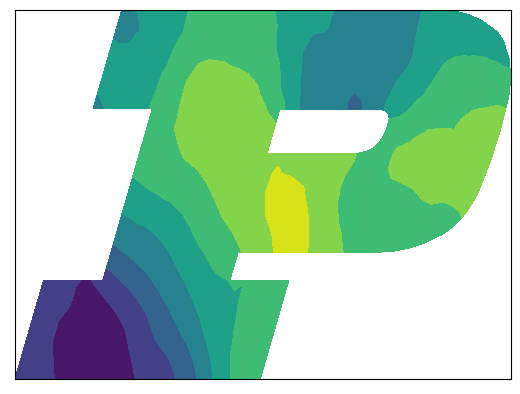

In [129]:
plt.xticks([])
plt.yticks([])
plt.tricontourf(m.verts[:,0], m.verts[:,1], m.connectivity, Z_t[:,0,4])